Step 0, Loss: 0.3570443391799927
Step 10, Loss: 0.36125409603118896
Step 20, Loss: 0.3653789460659027
Step 30, Loss: 0.369411826133728
Step 40, Loss: 0.3733496069908142
Step 50, Loss: 0.37719404697418213
Step 60, Loss: 0.38091951608657837
Step 70, Loss: 0.384593665599823
Step 80, Loss: 0.3882297873497009
Step 90, Loss: 0.3918142020702362


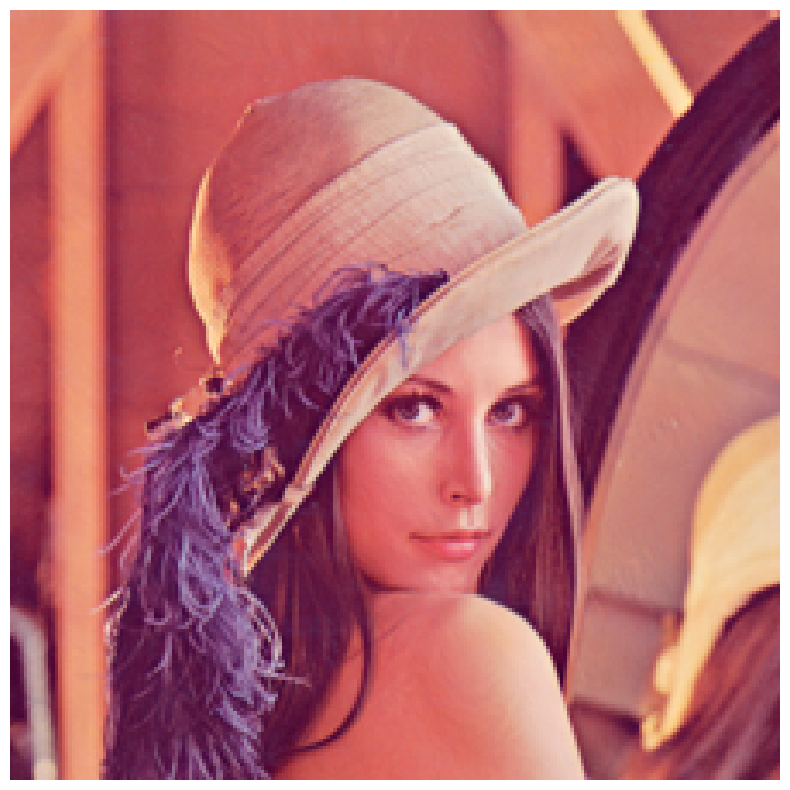

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 加载预训练的InceptionV3模型
base_model = InceptionV3(include_top=False, weights='imagenet')

# 选择要放大的卷积层
layer_names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in layer_names]

# 创建一个模型，该模型返回所选择层的激活值
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)


# 定义一个损失函数，以放大层中的激活值
def compute_loss(input_image):
    features = dream_model(input_image)
    loss = tf.reduce_mean([tf.reduce_mean(feature) for feature in features])
    return loss


# 梯度上升步骤
@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    grads = tape.gradient(loss, img)
    grads = tf.math.l2_normalize(grads)  # 归一化梯度
    img += learning_rate * grads
    return img


# 运行DeepDream算法
def deep_dream(image, steps=100, learning_rate=0.01, step_size=10):
    img = tf.convert_to_tensor(image)
    img = tf.expand_dims(img, axis=0)  # 添加批次维度

    for step in range(steps):
        img = gradient_ascent_step(img, learning_rate)
        if step % step_size == 0:
            print(f"Step {step}, Loss: {compute_loss(img)}")

    img = img[0].numpy()  # 移除批次维度
    return img


# 图像预处理和后处理函数
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    img = img.astype(np.float32)
    return img


def deprocess_image(img):
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    return img


# 加载和处理图像
image_path = '../assets/lena/lena_std.jpg'  # 替换为你的图片路径
img = preprocess_image(image_path)

# 执行DeepDream算法
dream_img = deep_dream(img, steps=100, learning_rate=0.01)

# 处理并显示结果图像
dream_img = deprocess_image(dream_img)
plt.figure(figsize=(10, 10))
plt.imshow(dream_img)
plt.axis('off')
plt.show()
